# Prerequisite

When u are not familiar with -> `pip install -r requirements.txt`, use this codeblock for installing the required packages

In [13]:
# !pip install jupyter
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import sklearn.metrics as metrics
import pickle

# Functions for evaluation purposes

In [15]:
def resultClassifierfloat(row):
    threshold = 0.5
    if (row['prediction'] > threshold and row['label'] == True):
        return 'TP'
    if (row['prediction'] < threshold and row['label'] == False):
        return 'TN'
    if (row['prediction'] < threshold and row['label'] == True):
        return 'FN'
    if (row['prediction'] > threshold and row['label'] == False):
        return 'FP'


def resultClassifierint(row):
    if (row['label'] == row['prediction'] and row['label'] == True):
        return 'TP'
    if (row['label'] == row['prediction'] and row['label'] == False):
        return 'TN'
    if (row['label'] != row['prediction'] and row['label'] == True):
        return 'FN'
    if (row['label'] != row['prediction'] and row['label'] == False):
        return 'FP'

# ! CHANGED THIS TO HANDLE 0 FP
def evaluation(model, name, X_test, y_test):
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy:  {accuracy_score(y_test, predictions):.4f}")
    print(f"Precision: {precision_score(y_test, predictions):.4f}")
    print(f"Recall:    {recall_score(y_test, predictions):.4f}")
    print(f"F1 Score:  {f1_score(y_test, predictions):.4f}")
    print(f"AUC Score: {roc_auc_score(y_test, probs):.4f}")
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f"Matrix:    TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# Load preprocessed data set

Split into train, test etc

In [16]:
print("Loading dataset.")
final_trainset = pd.read_csv('trainset_reconstructed.csv').fillna(0)

# Filter for high-confidence matches (>88%) to remove noise
df_scores = pd.read_csv('data/full_matches.csv')

# Add the '%' column to our training set
final_trainset = pd.merge(final_trainset, df_scores[['child_id', 'parent_id', '%']], 
                          on=['child_id', 'parent_id'], how='left')

# Convert score to numeric (just in case)
final_trainset['%'] = pd.to_numeric(final_trainset['%'], errors='coerce').fillna(0)

# Apply the 0.88 Threshold (88%)
# We keep matches > 0.88. We keep ALL non-matches (0).
clean_positives = final_trainset[(final_trainset['match'] == 1) & (final_trainset['%'] >= 0.88)]
clean_negatives = final_trainset[final_trainset['match'] == 0]

# Re-balance negatives to 50/50 (Downsample to match the new, smaller positive count)
if len(clean_positives) > 0:
    clean_negatives = clean_negatives.sample(n=len(clean_positives), random_state=42)
    final_trainset = pd.concat([clean_positives, clean_negatives]).sample(frac=1, random_state=42).fillna(0)
    print(f"Filtered Dataset Size: {len(final_trainset)} rows.")
else:
    print("No matches found above the threshold.")

# Define the target
target = 'match'

# Split the data into 80% train and 20% test (using GroupShuffleSplit to prevent data leak)
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=42)
train_inds, test_inds = next(splitter.split(final_trainset, groups=final_trainset['child_id']))

train_set = final_trainset.iloc[train_inds]
test_set = final_trainset.iloc[test_inds]

print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Loading dataset.
Filtered Dataset Size: 113592 rows.
Training set size: 90871
Test set size: 22721


# Traininig Phase (English / Initial Model)

In [17]:
# Legacy features
feature_cols_legacy = ['title_sim_legacy', 'content_sim_legacy', 'date_binary']

X_train_legacy = train_set[feature_cols_legacy]
y_train = train_set[target]

X_test_legacy = test_set[feature_cols_legacy]
y_test = test_set[target]

# Random forest (same settings as before)
rf_legacy = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_legacy.fit(X_train_legacy, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [19]:
'''
filename = 'model_rf_initial.pkl'
pickle.dump(rf_legacy, open(filename, 'wb'))
print(f"Saved: {filename}")
'''

'\nfilename = \'model_rf_initial.pkl\'\npickle.dump(rf_legacy, open(filename, \'wb\'))\nprint(f"Saved: {filename}")\n'

# Training Phase (Dutch / Fixed Model)

In [20]:
# Dutch features
feature_cols_dutch = ['title_sim_dutch', 'content_sim_dutch', 'date_binary']

X_train_dutch = train_set[feature_cols_dutch]
y_train = train_set[target]

X_test_dutch = test_set[feature_cols_dutch]
y_test = test_set[target]

# Same random forest
rf_dutch = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_dutch.fit(X_train_dutch, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [ ]:
'''
filename = 'model_rf_fixed.pkl'
pickle.dump(rf_dutch, open(filename, 'wb'))
print(f"Saved: {filename}")
'''

# Evaluation Phase (Both)

In [24]:
evaluation(rf_legacy, "Legacy Model (Jaccard/Stemming)", X_test_legacy, y_test)


--- Legacy Model (Jaccard/Stemming) Results ---
Accuracy:  0.9879
Precision: 0.9960
Recall:    0.9800
F1 Score:  0.9879
AUC Score: 0.9935
Matrix:    TP=11249, FP=45, TN=11197, FN=230


In [21]:
evaluation(rf_dutch, "New Model (Dutch Vectors)", X_test_dutch, y_test)


--- New Model (Dutch Vectors) Results ---
Accuracy:  0.9857
Precision: 0.9946
Recall:    0.9769
F1 Score:  0.9857
AUC Score: 0.9935
Matrix:    TP=11214, FP=61, TN=11181, FN=265


Comparing the models:

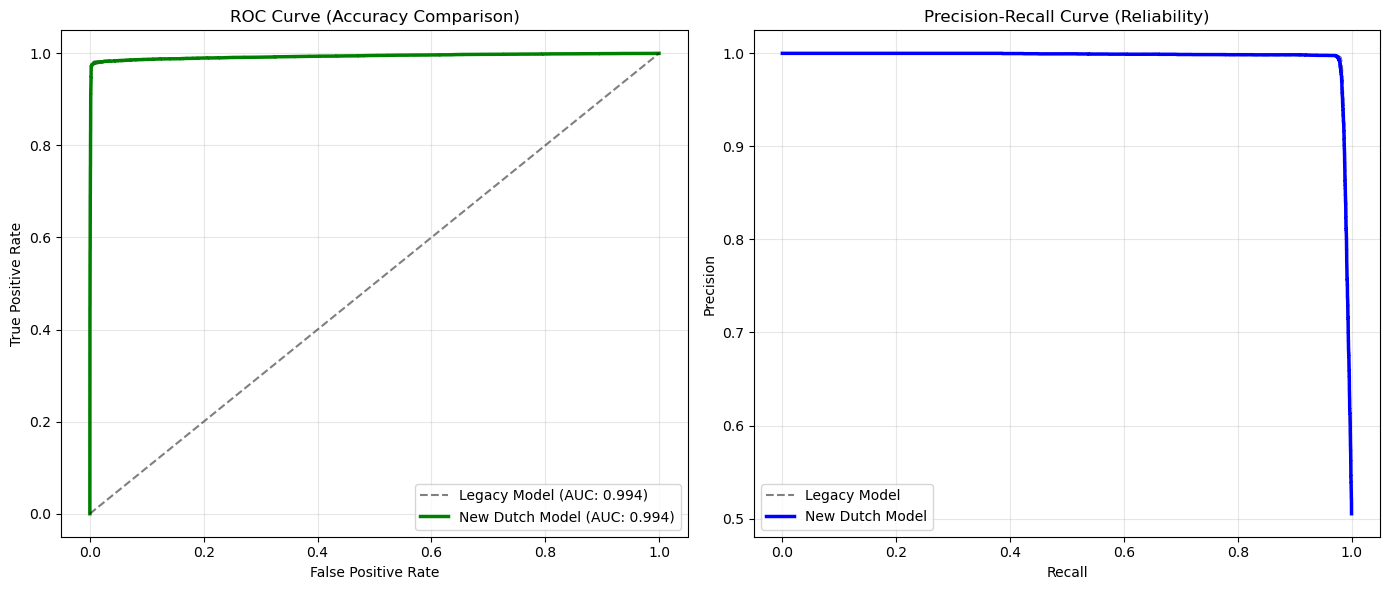

In [23]:
# Get probabilities for the curve
probs_legacy = rf_legacy.predict_proba(X_test_legacy)[:, 1]
probs_dutch = rf_dutch.predict_proba(X_test_dutch)[:, 1]

# Plot ROC Curve
fpr_a, tpr_a, _ = roc_curve(y_test, probs_legacy)
fpr_b, tpr_b, _ = roc_curve(y_test, probs_dutch)

plt.figure(figsize=(14, 6))

# Subplot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_a, tpr_a, label=f'Legacy Model (AUC: {auc(fpr_a, tpr_a):.3f})', linestyle='--', color='grey')
plt.plot(fpr_b, tpr_b, label=f'New Dutch Model (AUC: {auc(fpr_b, tpr_b):.3f})', color='green', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Accuracy Comparison)')
plt.legend()
plt.grid(alpha=0.3)

# Subplot Precision-Recall
prec_a, rec_a, _ = precision_recall_curve(y_test, probs_legacy)
prec_b, rec_b, _ = precision_recall_curve(y_test, probs_dutch)

plt.subplot(1, 2, 2)
plt.plot(rec_a, prec_a, label='Legacy Model', linestyle='--', color='grey')
plt.plot(rec_b, prec_b, label='New Dutch Model', color='blue', linewidth=2.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Reliability)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
#plt.savefig('model_comparison.png')
plt.show()